<a href="https://colab.research.google.com/github/Lazarus-GS/NOMA-FYP-MATLAB/blob/main/ML%20Model/ScoreIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from scipy.optimize import minimize

# Load data
data_url = "https://raw.githubusercontent.com/Lazarus-GS/NOMA-FYP-MATLAB/main/New/simulation_dataset2.csv"
df = pd.read_csv(data_url)

# Normalize function
def normalize(column):
    return (column - column.min()) / (column.max() - column.min())

# Add normalized columns
df['NormalizedSumRateNear'] = normalize(df['SumRateNearUser'])
df['NormalizedSumRateFar'] = normalize(df['SumRateFarUser'])
df['NormalizedBERNear'] = normalize(df['BERNearUser'])
df['NormalizedBERFar'] = normalize(df['BERFarUser'])
df['NormalizedOutageNear'] = normalize(df['OutageProbNearUser'])
df['NormalizedOutageFar'] = normalize(df['OutageProbFarUser'])

# Score function
def calculate_score(weights, data):
    w1, w2, w3 = weights
    scores = w1 * (data['NormalizedSumRateNear'] + data['NormalizedSumRateFar']) \
             - w2 * (data['NormalizedBERNear'] + data['NormalizedBERFar']) \
             - w3 * (data['NormalizedOutageNear'] + data['NormalizedOutageFar'])
    return scores


In [ ]:
# Step 3: Objective function
def objective(weights, data):
    scores = calculate_score(weights, data)
    # We negate since we want to maximize the score, but the optimization function minimizes
    return -scores.mean()

# Initial weights
initial_weights = [0.5, 0.25, 0.25]

# Optimization bounds (weights between 0 and 1)
bounds = [(0, 1) for _ in initial_weights]

# Step 4: Optimization for NOMA
noma_data = df[df['MAScheme'] == 'NOMA']
result_noma = minimize(objective, initial_weights, args=(noma_data), bounds=bounds)
optimized_weights_noma = result_noma.x

# Optimization for OMA
oma_data = df[df['MAScheme'] == 'OMA']
result_oma = minimize(objective, initial_weights, args=(oma_data), bounds=bounds)
optimized_weights_oma = result_oma.x

print(f"Optimized weights for NOMA: {optimized_weights_noma}")
print(f"Optimized weights for OMA: {optimized_weights_oma}")


Optimized weights for NOMA: [1. 0. 0.]
Optimized weights for OMA: [1. 0. 0.]


In [ ]:
pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
import random

# Load the dataset
url = "https://raw.githubusercontent.com/Lazarus-GS/NOMA-FYP-MATLAB/main/New/simulation_dataset2.csv"
df = pd.read_csv(url)

# Normalize the columns
def normalize(column):
    return (column - column.min()) / (column.max() - column.min())

# Relevant columns to normalize
cols_to_normalize = ['SumRateFarUser', 'SumRateNearUser', 'BERFarUser', 'BERNearUser', 'OutageProbFarUser', 'OutageProbNearUser']
for col in cols_to_normalize:
    df[f'Normalized{col}'] = normalize(df[col])

# Scenarios with initial weights
scenarios = {
    "eMBB": [0.7, 0.15, 0.15],
    "URLLC": [0.2, 0.4, 0.4],
    "mMTC": [0.5, 0.25, 0.25]
}

# Define the objective function to calculate the score
def calculate_score(weights, df_sub):
    w1, w2, w3 = weights
    scores = w1 * (df_sub['NormalizedSumRateNearUser'] + df_sub['NormalizedSumRateFarUser']) \
            - w2 * (df_sub['NormalizedBERNearUser'] + df_sub['NormalizedBERFarUser']) \
            - w3 * (df_sub['NormalizedOutageProbNearUser'] + df_sub['NormalizedOutageProbFarUser'])
    scores = normalize(scores)
    return scores

# Define the optimization problem
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation function for the optimization
def evaluate(individual):
    weights = individual
    scores_oma = calculate_score(weights, df[df['MAScheme'] == 'OMA'])
    scores_noma = calculate_score(weights, df[df['MAScheme'] == 'NOMA'])
    return sum(scores_oma) + sum(scores_noma),

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Optimize weights for each scenario
optimized_weights = {}

for scenario, initial_weights in scenarios.items():
    print(f"\nOptimizing weights for {scenario} scenario...\n")

    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, stats=stats, halloffame=hof, verbose=True)

    optimized_weights[scenario] = hof[0]

print("\nOptimized Weights:")
for scenario, weights in optimized_weights.items():
    print(f"{scenario}: {weights}")


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Optimizing weights for eMBB scenario...

gen	nevals	avg    	min    	max    
0  	50    	20315.3	9047.62	34761.6
1  	28    	25490.4	8735.4 	37943.1
2  	27    	30559.6	23386.5	41732.9
3  	28    	33330.5	25700.5	40830.5
4  	32    	35919.4	26721.1	42181.9
5  	40    	38720.3	33027.9	45854.1
6  	25    	41150.3	34435.6	46649.5
7  	37    	43244.1	33250  	55774  
8  	33    	48228.5	40663.4	106475 
9  	29    	50529.7	42567.6	106475 
10 	29    	55871.7	44755  	96739.1
11 	28    	67765.7	40700.6	140796 
12 	31    	89637.9	48239.3	140796 
13 	30    	111446 	52628  	149979 
14 	40    	129130 	56382.4	184975 
15 	35    	153713 	118186 	197195 
16 	28    	170836 	143855 	198508 
17 	30    	184693 	157448 	201955 
18 	14    	193635 	135435 	203834 
19 	26    	199720 	175983 	226712 
20 	32    	202836 	143837 	232526 
21 	33    	211137 	178976 	232526 
22 	34    	218840 	194353 	232538 
23 	30    	225510 	204897 	232635 
24 	33    	229832 	217953 	233063 
25 	28    	232253 	225925 	233228 
26 	22    	23

In [ ]:
!pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15080 sha256=9806a3333796cc5c8e27ea6414bca6ad0f70ae7efbef34bbfeabdac426374abd
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [ ]:
import numpy as np
import pandas as pd
from geneticalgorithm import geneticalgorithm as ga

# Load dataset
url = "https://raw.githubusercontent.com/Lazarus-GS/NOMA-FYP-MATLAB/main/New/simulation_dataset2.csv"
df = pd.read_csv(url)

# Initial weights for different scenarios
scenarios = {
    "eMBB": [0.7, 0.15, 0.15],
    "URLLC": [0.2, 0.4, 0.4],
    "mMTC": [0.5, 0.25, 0.25]
}


In [ ]:
def normalize(column):
    return (column - column.min()) / (column.max() - column.min())

def calculate_score(weights, importance_factors):
    w1, w2, w3 = weights
    normalized_capacity = normalize(df['SumRateNearUser'] + df['SumRateFarUser'])
    normalized_ber = normalize(df['BERNearUser'] + df['BERFarUser'])
    normalized_outage = normalize(df['OutageProbNearUser'] + df['OutageProbFarUser'])

    score = importance_factors[0] * (w1 * normalized_capacity) \
            - importance_factors[1] * (w2 * normalized_ber) \
            - importance_factors[2] * (w3 * normalized_outage)

    return -np.mean(score)

def eMBB(weights):
    return calculate_score(weights, [0.7, 0.15, 0.15])

def URLLC(weights):
    return calculate_score(weights, [0.2, 0.4, 0.4])

def mMTC(weights):
    return calculate_score(weights, [0.5, 0.25, 0.25])

In [ ]:
varbound = np.array([[0, 1]]*3)  # Three variables, each bounded by [0, 1]
algorithm_param = {
    'max_num_iteration': 1000,
    'population_size': 10,
    'mutation_probability': 0.1,
    'elit_ratio': 0.01,
    'crossover_probability': 0.5,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': None
}

evaluation_funcs = {
    'eMBB': eMBB,
    'URLLC': URLLC,
    'mMTC': mMTC
}

 The best solution found:
 [9.99895377e-01 8.87596170e-04 1.08429603e-03]

 Objective function:
 -0.024817644116223607


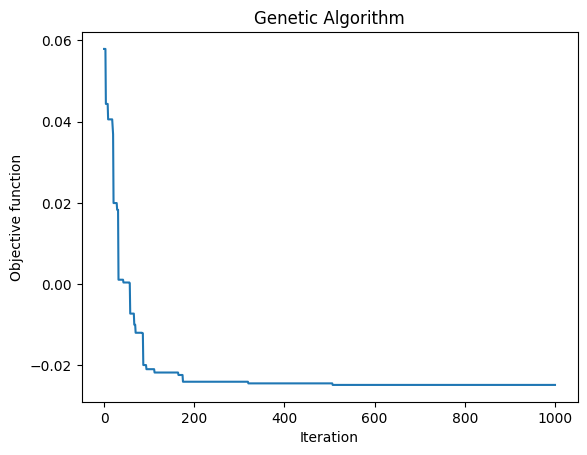

Optimized Weights for eMBB: [9.98031783e-01 8.85941878e-04 1.08227513e-03]
 The best solution found:
 [9.99850595e-01 4.36579863e-03 2.99732059e-04]

 Objective function:
 -0.0056018746105197924


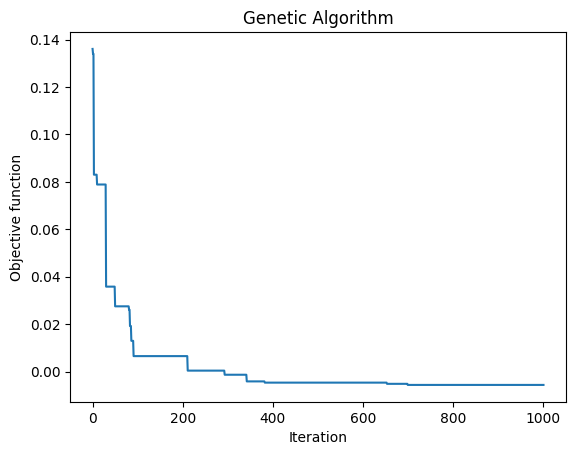

Optimized Weights for URLLC: [9.95355445e-01 4.34617077e-03 2.98384518e-04]
 The best solution found:
 [0.99846788 0.00190216 0.00194657]

 Objective function:
 -0.017026285767816247


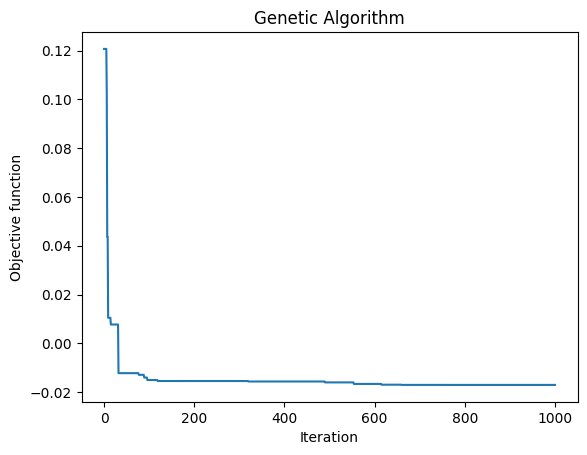

Optimized Weights for mMTC: [0.99616017 0.00189776 0.00194207]


In [ ]:
def set_initial_population(model, weights):
    population_size = model.param['population_size']
    initial_population = np.random.uniform(0, 1, (population_size, model.dim))
    initial_population[0] = weights
    return initial_population

for scenario, init_weights in scenarios.items():
    model = ga(function=evaluation_funcs[scenario], dimension=3, variable_type='real', variable_boundaries=varbound,
               algorithm_parameters=algorithm_param)

    model.initial_population = set_initial_population(model, init_weights)

    model.run()
    optimized_weights = model.output_dict['variable'] / np.sum(model.output_dict['variable'])
    print(f"Optimized Weights for {scenario}: {optimized_weights}")